## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import gauss, seed
from scipy import stats
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from matplotlib import style
style.use('ggplot')


%matplotlib inline

In [2]:
budget = pd.read_csv('zippedData/tn.movie_budgets.csv')

In [3]:
budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [5]:
#change dates to datetime objects
budget['release_date'] = pd.to_datetime(budget['release_date'])

In [6]:
#remove commas from gross figures
budget = budget.replace(',','', regex=True)

In [7]:
#removing '$' from:
budget['production_budget']= budget['production_budget'].str[1:]
budget['domestic_gross'] = budget['domestic_gross'].str[1:]
budget['worldwide_gross'] = budget['worldwide_gross'].str[1:]

In [8]:
#using astype() to convert to 'int'
budget[['production_budget', 'domestic_gross', 'worldwide_gross']] = budget[['production_budget', 
                                                                             'domestic_gross', 'worldwide_gross']].astype(int)

In [9]:
#sanity check
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 271.2+ KB


In [10]:
#Create a new column to determine 'ROI' based on gross revenue and production cost
budget["return_on_investment"]= budget['worldwide_gross']/budget['production_budget']

In [11]:
#convert to datetime object & narrow down to films made after 2010
budget['year'] = budget['release_date'].dt.year
budget_recent = budget.loc[budget['year']>2010]
budget_recent['return_on_investment'].describe()

count    1920.000000
mean        3.285546
std        11.055955
min         0.000000
25%         0.200260
50%         1.613252
75%         3.635941
max       416.564740
Name: return_on_investment, dtype: float64

In [12]:
#dropping significant outliers
budget_recent.drop(budget_recent[budget_recent['return_on_investment'] == 416.564740].index, inplace = True)

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Merging the budget dataframe with the IMDB data pulled from SQL

In [13]:
#imports and connect to SQL
import sqlite3
import pandasql
import matplotlib.pyplot as plt


conn = sqlite3.connect('zippedData/im.db')

In [14]:
#creating a dataframe with relevant information from IMDB database
imdb_ratings = pd.read_sql(
    """
    SELECT basics.movie_id, basics.primary_title, basics.original_title, 
    basics.runtime_minutes, basics.genres, ratings.averagerating, ratings.numvotes
    FROM movie_basics as basics
        JOIN movie_ratings as ratings
            USING(movie_id)
    """, conn
)

In [15]:
imdb_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   runtime_minutes  66236 non-null  float64
 4   genres           73052 non-null  object 
 5   averagerating    73856 non-null  float64
 6   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 3.9+ MB


In [16]:
imdb_ratings.head()

,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,80.0,"Comedy,Drama,Fantasy",6.5,119


In [17]:
budget_cleaned = budget_recent

In [18]:
#removing duplicates from the movie title column in each dataframe before merging them
imdb_ratings = imdb_ratings.drop_duplicates(subset=['primary_title'])
budget_cleaned = budget_cleaned.drop_duplicates(subset=['movie'])

In [19]:
#merge imdb data with our movie budget data
all_recent = pd.merge(budget_cleaned, imdb_ratings, left_on='movie', right_on='primary_title', how='inner')
all_recent

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment,year,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624
1,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,0.427892,2019,tt6565702,Dark Phoenix,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,4.243841,2015,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,6.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926
4,9,2017-11-17,Justice League,300000000,229024295,655945209,2.186484,2017,tt0974015,Justice League,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,59,2011-11-25,The Ridges,17300,0,0,0.000000,2011,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127
1586,62,2014-12-31,Stories of Our Lives,15000,0,0,0.000000,2014,tt3973612,Stories of Our Lives,Stories of Our Lives,60.0,Drama,7.5,85
1587,73,2012-01-13,Newlyweds,9000,4584,4584,0.509333,2012,tt1880418,Newlyweds,Newlyweds,95.0,"Comedy,Drama",6.4,1436
1588,78,2018-12-31,Red 11,7000,0,0,0.000000,2018,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43


In [20]:
#duplicates sanity check
all_recent['movie'].duplicated().value_counts()

False    1590
Name: movie, dtype: int64

In [21]:
all_recent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1590 entries, 0 to 1589
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1590 non-null   int64         
 1   release_date          1590 non-null   datetime64[ns]
 2   movie                 1590 non-null   object        
 3   production_budget     1590 non-null   int64         
 4   domestic_gross        1590 non-null   int64         
 5   worldwide_gross       1590 non-null   int64         
 6   return_on_investment  1590 non-null   float64       
 7   year                  1590 non-null   int64         
 8   movie_id              1590 non-null   object        
 9   primary_title         1590 non-null   object        
 10  original_title        1590 non-null   object        
 11  runtime_minutes       1572 non-null   float64       
 12  genres                1588 non-null   object        
 13  averagerating     

In [22]:
all_recent = all_recent.dropna()

In [23]:
#create a column sorts films based on 'high' or 'low' production budget
conditions = [
    (all_recent['production_budget'] <= 15000000),
    (all_recent['production_budget'] > 15000000)]

#create a list of the values we want to assign for each condition
values = ['low_budget', 'high_budget']

#create a new column and use np.select to assign values to it using our lists as arguments
all_recent['budget_class'] = np.select(conditions, values)
all_recent

<ipython-input-23-068bcbac2e14>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_recent['budget_class'] = np.select(conditions, values)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment,year,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_class
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624,high_budget
1,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,0.427892,2019,tt6565702,Dark Phoenix,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,high_budget
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,4.243841,2015,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,high_budget
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,6.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,high_budget
4,9,2017-11-17,Justice League,300000000,229024295,655945209,2.186484,2017,tt0974015,Justice League,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135,high_budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,59,2011-11-25,The Ridges,17300,0,0,0.000000,2011,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127,low_budget
1586,62,2014-12-31,Stories of Our Lives,15000,0,0,0.000000,2014,tt3973612,Stories of Our Lives,Stories of Our Lives,60.0,Drama,7.5,85,low_budget
1587,73,2012-01-13,Newlyweds,9000,4584,4584,0.509333,2012,tt1880418,Newlyweds,Newlyweds,95.0,"Comedy,Drama",6.4,1436,low_budget
1588,78,2018-12-31,Red 11,7000,0,0,0.000000,2018,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,low_budget



# Pulling Horror Films

In [24]:
#creating function to identify which rows contain 'Horror'
def horror(x):
    if "Horror" in x:
        return True
    else:
        return False

In [25]:
#creating new boolean column to indentify Horror films, using the above function
all_recent['Horror']=all_recent['genres'].map(horror)
all_recent['Horror'].value_counts()

<ipython-input-25-c3da41b8e6b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_recent['Horror']=all_recent['genres'].map(horror)


False    1366
True      204
Name: Horror, dtype: int64

### Horror Hypothesis Test

Null hypothesis: On average, horror films do not have a different return on investment compared to other genres or they have a lower return. Alternative hypothesis: Horror films have a higher return on investment than other genres.



In [26]:
alpha=.05
horror_sample = all_recent.loc[all_recent['Horror']==True]
others_sample=all_recent.loc[all_recent['Horror']==False]

In [27]:
horror_sample['return_on_investment'].describe()

count    204.000000
mean       5.897760
std       12.356164
min        0.000000
25%        0.037801
50%        1.356258
75%        5.529019
max      101.759490
Name: return_on_investment, dtype: float64

In [28]:
horror=horror_sample['return_on_investment']

In [29]:
others_sample['return_on_investment'].describe()

count    1366.000000
mean        2.743449
std         3.893189
min         0.000000
25%         0.372774
50%         1.747782
75%         3.533994
max        55.792961
Name: return_on_investment, dtype: float64

In [30]:
others=others_sample['return_on_investment']

In [31]:
#two-sample t-test
statistic, pvalue = stats.ttest_ind(horror, others, equal_var=False)
pvalue / 2

0.00018518932745691132

In [32]:
(pvalue/2)<alpha

True

Reject the null hypothesis. Horror films have a statistically significant higher return on investment compared to other genres, on average.



## Horror Genre - Budget & ROI Hypothesis Test

In [33]:
#creating samples to run t-test
low_budget_hor = horror_sample.loc[horror_sample['budget_class'] == 'low_budget']
high_budget_hor = horror_sample.loc[horror_sample['budget_class'] == 'high_budget']

In [34]:
low_budget_hor['return_on_investment'].mean()

7.003820863061332

In [35]:
high_budget_hor['return_on_investment'].mean()

2.66466076579254

In [36]:
#running the t-test with alpha = 5%
alpha = .05
result = stats.ttest_ind(low_budget_hor['return_on_investment'], high_budget_hor['return_on_investment'])
pval = result[1]/2 #divide by two because we are interested in a one-sided test
print(pval)

0.014233150027950494


In [37]:
#check p-value against our alpha of .05
pval < alpha

True

Reject the null hypothesis. Low budget Horror films have a statistically significant higher return on investment, on average, compared to high budget horror films.

## Plotting the regression line & Calculating R-squared

In [38]:
#find slope 'm'
def slope(x, y):
    rho = np.corrcoef(x, y)[0][1]
    s_y = y.std()
    s_x = x.std()

    m = rho * s_y / s_x
    return m
    
m = slope(horror_sample['production_budget'], horror_sample['return_on_investment'])

In [39]:
#find intercept 'c'
def intercept(m, x, y):
    y_mean = y.mean()
    x_mean = x.mean()

    # calculating intercept estimate
    c = y_mean - m * x_mean
    return c
    
c = intercept(m, horror_sample['production_budget'], horror_sample['production_budget'])

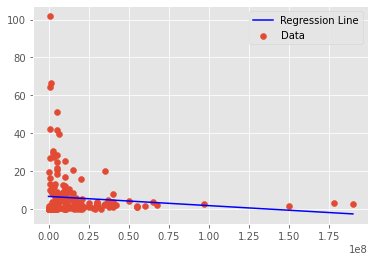

In [40]:
#Plotting the line for ENTIRE HORROR SAMPLE
def best_fit(x, y):
    # Create a scatter plot of x vs. y
    fig, ax = plt.subplots()
    ax.scatter(x, y, label="Data")

    # Calculate coefficient and intercept
    m = slope(x, y)
    c = intercept(m, x, y)
    
    # Plot line created by coefficient and intercept
    regression_line = m * x + c
    ax.plot(x, regression_line, label= "Regression Line", color='red')
    ax.get_lines()[0].set_color("blue")
    ax.legend()
    
best_fit(horror_sample['production_budget'], horror_sample['return_on_investment'])

## Creating ROI Mean & Budget Tier Dataframe to plot Regression Line

In [41]:
#create a list of our conditions
conditions = [
    (horror_sample['production_budget'] <= 7500000),
    (horror_sample['production_budget'] > 7500000) & (horror_sample['production_budget'] <= 11000000),
    (horror_sample['production_budget'] > 1100000) & (horror_sample['production_budget'] <= 15000000),
    (horror_sample['production_budget'] > 15000000)]

#create a list of the values we want to assign for each condition
values = ['tier_1', 'tier_2', 'tier_3', 'tier_4']

#create a new column and use np.select to assign values to it using our lists as arguments
horror_sample['budget_tier'] = np.select(conditions, values)
horror_sample

<ipython-input-41-2d3c6474d310>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horror_sample['budget_tier'] = np.select(conditions, values)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment,year,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_class,Horror,budget_tier
43,69,2013-06-21,World War Z,190000000,202359711,531514650,2.797446,2013,tt0816711,World War Z,World War Z,116.0,"Action,Adventure,Horror",7.0,553751,high_budget,True,tier_4
60,94,2018-08-10,The Meg,178000000,145443742,529530715,2.974892,2018,tt4779682,The Meg,The Meg,113.0,"Action,Horror,Sci-Fi",5.7,114042,high_budget,True,tier_4
106,89,2012-05-11,Dark Shadows,150000000,79727149,238202668,1.588018,2012,tt1077368,Dark Shadows,Dark Shadows,113.0,"Comedy,Fantasy,Horror",6.2,229818,high_budget,True,tier_4
198,12,2017-05-19,Alien: Covenant,97000000,74262031,238521247,2.458982,2017,tt2316204,Alien: Covenant,Alien: Covenant,122.0,"Horror,Sci-Fi,Thriller",6.4,226920,high_budget,True,tier_4
278,65,2012-06-22,Abraham Lincoln: Vampire Hunter,67500000,37519139,137489730,2.036885,2012,tt1611224,Abraham Lincoln: Vampire Hunter,Abraham Lincoln: Vampire Hunter,105.0,"Action,Fantasy,Horror",5.9,142853,high_budget,True,tier_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,35,2013-10-25,Her Cry: La Llorona Investigation,35000,0,0,0.000000,2013,tt2469216,Her Cry: La Llorona Investigation,Her Cry: La Llorona Investigation,89.0,Horror,3.7,70,low_budget,True,tier_1
1580,49,2015-09-01,Exeter,25000,0,489792,19.591680,2015,tt1945044,Exeter,Exeter,91.0,"Horror,Mystery,Thriller",4.5,5156,low_budget,True,tier_1
1585,59,2011-11-25,The Ridges,17300,0,0,0.000000,2011,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127,low_budget,True,tier_1
1588,78,2018-12-31,Red 11,7000,0,0,0.000000,2018,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,low_budget,True,tier_1


In [42]:
#creating dataframe for each budget tier
tier4_hor = horror_sample.loc[horror_sample['budget_tier'] == 'tier_4']
tier3_hor = horror_sample.loc[horror_sample['budget_tier'] == 'tier_3']
tier2_hor = horror_sample.loc[horror_sample['budget_tier'] == 'tier_2']
tier1_hor = horror_sample.loc[horror_sample['budget_tier'] == 'tier_1']

In [43]:
#retrieving the mean ROI for each budget tier
tier4_hor_roim = horror_sample.loc[horror_sample['budget_tier'] == 'tier_4']['return_on_investment'].mean()
tier3_hor_roim = horror_sample.loc[horror_sample['budget_tier'] == 'tier_3']['return_on_investment'].mean()
tier2_hor_roim = horror_sample.loc[horror_sample['budget_tier'] == 'tier_2']['return_on_investment'].mean()
tier1_hor_roim = horror_sample.loc[horror_sample['budget_tier'] == 'tier_1']['return_on_investment'].mean()
print(tier4_hor_roim, tier3_hor_roim, tier2_hor_roim, tier1_hor_roim)

2.66466076579254 5.751416179443601 6.442151812147419 7.235902009870812


In [44]:
#creating a new df of budget tier ROI means to plot
horror_roi_means = {
    'Tiers':[4,3,2,1],
    'ROI_Mean':[tier4_hor_roim, tier3_hor_roim, tier2_hor_roim, tier1_hor_roim]}
    
horror_roi_means_df = pd.DataFrame(horror_roi_means)
print(horror_roi_means_df)

   Tiers  ROI_Mean
0      4  2.664661
1      3  5.751416
2      2  6.442152
3      1  7.235902


(None, -4.8696682706440507e-08, 13785616.847784366)

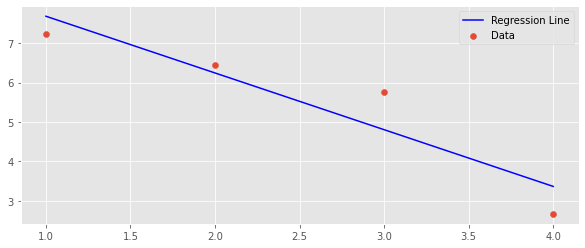

In [45]:
#Plotting Regression Line
def best_fit(x, y):
    # Create a scatter plot of x vs. y
    fig, ax = plt.subplots(figsize=(10,4))
    ax.scatter(x, y, label="Data")

    # Calculate coefficient and intercept
    m = slope(x, y)
    c = intercept(m, x, y)
    
    # Plot line created by coefficient and intercept
    regression_line = m * x + c
    ax.plot(x, regression_line, label= "Regression Line", color='red')
    ax.get_lines()[0].set_color("blue")
    ax.legend()
    
best_fit(horror_roi_means_df['Tiers'], horror_roi_means_df['ROI_Mean']), m, c

In [46]:
#creating arrays to pass through r-squared function
horror_roi_means_array = horror_roi_means_df['ROI_Mean'].array
horror_tier_array = horror_roi_means_df[["Tiers"]] 

In [47]:
from sklearn.linear_model import LinearRegression

#initiate linear regression model
model = LinearRegression()

#define predictor and response variables
X, y = horror_tier_array, horror_roi_means_array

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)

#view R-squared value
print(r_squared)

0.8644524106240016



## EDA of relationship between month of release & ROI

In [48]:
#Create new column for month
all_recent['release_date'] = pd.to_datetime(all_recent['release_date'])
all_recent['release_month'] = all_recent['release_date'].dt.month

<ipython-input-48-3bf25eb134ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_recent['release_date'] = pd.to_datetime(all_recent['release_date'])
<ipython-input-48-3bf25eb134ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_recent['release_month'] = all_recent['release_date'].dt.month


###  Bar chart showing all movies ROI by month


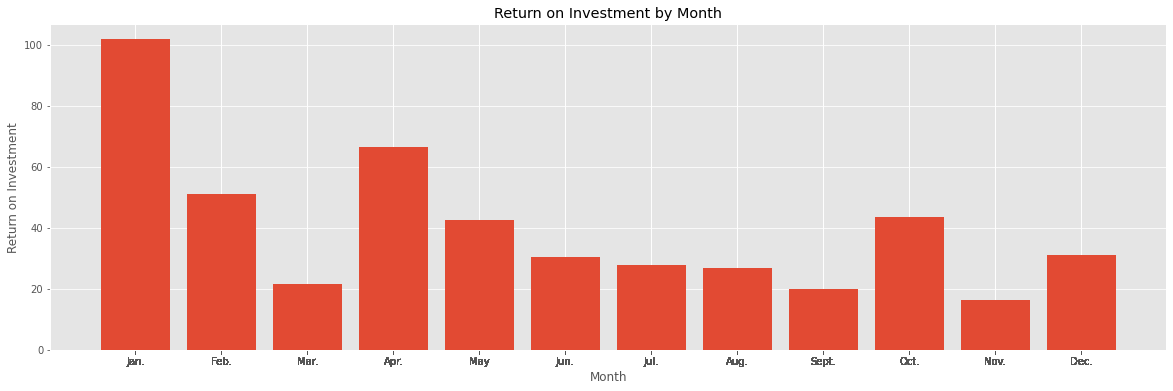

In [49]:
# Bar chart of return on investment by month
plt.figure(figsize=(20, 6))
plt.bar(all_recent['release_month'], all_recent['return_on_investment'])

month_labels = {1: 'Jan.', 2: 'Feb.', 3: 'Mar.', 4: 'Apr.', 5: 'May', 6: 'Jun.', 7: 'Jul.', 8: 'Aug.', 9: 'Sept.', 10: 'Oct.', 11: 'Nov.', 12: 'Dec.'}
x_labels = [month_labels.get(month, str(month)) for month in all_recent['release_month']]
plt.xlabel('Month')
plt.ylabel('Return on Investment')
plt.title('Return on Investment by Month')
plt.xticks(all_recent['release_month'], x_labels)

plt.show()

In [50]:
all_recent['return_on_investment'].describe()

count    1570.000000
mean        3.153308
std         5.836533
min         0.000000
25%         0.293002
50%         1.723703
75%         3.740724
max       101.759490
Name: return_on_investment, dtype: float64

### Statistical testing for return on investment based on release month of the movie

In [51]:
mean_by_month = all_recent.groupby('release_month')['return_on_investment'].mean()
mean_by_month

release_month
1     4.619487
2     3.337229
3     2.492694
4     3.539935
5     2.987794
6     3.579112
7     3.830641
8     2.544328
9     2.542265
10    3.947785
11    3.113364
12    2.052060
Name: return_on_investment, dtype: float64

In [52]:
# One-way ANOVA
result = stats.f_oneway(
    all_recent[all_recent['release_month'] == 1]['return_on_investment'],
    all_recent[all_recent['release_month'] == 2]['return_on_investment'],
    all_recent[all_recent['release_month'] == 3]['return_on_investment'],
    all_recent[all_recent['release_month'] == 4]['return_on_investment'],
    all_recent[all_recent['release_month'] == 5]['return_on_investment'],
    all_recent[all_recent['release_month'] == 6]['return_on_investment'],
    all_recent[all_recent['release_month'] == 7]['return_on_investment'],
    all_recent[all_recent['release_month'] == 8]['return_on_investment'],
    all_recent[all_recent['release_month'] == 9]['return_on_investment'],
    all_recent[all_recent['release_month'] == 10]['return_on_investment'],
    all_recent[all_recent['release_month'] == 11]['return_on_investment'],
    all_recent[all_recent['release_month'] == 12]['return_on_investment']
)

result


F_onewayResult(statistic=2.1389955500368725, pvalue=0.01541094838723776)

#### This shows us that there is a signficant difference between the months, but not which months. To figure that out, we need to run post-hoc tests.

In [53]:
#One-way ANOVA
model = ols('return_on_investment ~ C(release_month)', data=all_recent).fit()
anova_table = sm.stats.anova_lm(model)

print("ANOVA Table:")
print(anova_table)

#Tukey HSD post hoc test
tukey_result = pairwise_tukeyhsd(all_recent['return_on_investment'], all_recent['release_month'])

print("Tukey HSD Post Hoc Test:")
print(tukey_result)

ANOVA Table:
                      df        sum_sq    mean_sq         F    PR(>F)
C(release_month)    11.0    795.166890  72.287899  2.138996  0.015411
Residual          1558.0  52653.006611  33.795255       NaN       NaN
Tukey HSD Post Hoc Test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -1.2823    0.9 -3.8734 1.3089  False
     1      3  -2.1268 0.1635 -4.5754 0.3218  False
     1      4  -1.0796    0.9 -3.5828 1.4237  False
     1      5  -1.6317 0.6326 -4.2284  0.965  False
     1      6  -1.0404    0.9 -3.5896 1.5088  False
     1      7  -0.7888    0.9 -3.3283 1.7506  False
     1      8  -2.0752 0.2253 -4.5871 0.4368  False
     1      9  -2.0772 0.1964 -4.5367 0.3823  False
     1     10  -0.6717    0.9 -3.1064  1.763  False
     1     11  -1.5061 0.6751 -3.9847 0.9725  False
     1     12  -2.5674 0.0194 -4.9258 -0.209   True
     2      3  -0.8445  

#### We see a significant difference on return on investment between January and December only even though the pvalue we got from the initial ANOVA was less (0.01) than alpha (0.05). This could be due to sample size of the individual months or due to the fact that the pvalues in the pairwise Tukey HSD are adjusted to adjust for the bias of doing many statistical tests.

In [54]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     return_on_investment   R-squared:                       0.015
Model:                              OLS   Adj. R-squared:                  0.008
Method:                   Least Squares   F-statistic:                     2.139
Date:                  Wed, 02 Aug 2023   Prob (F-statistic):             0.0154
Time:                          17:09:13   Log-Likelihood:                -4985.2
No. Observations:                  1570   AIC:                             9994.
Df Residuals:                      1558   BIC:                         1.006e+04
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.6195      0.570      8.104      0.000       3.501       5.738
C(release_month)[T.2]     -1.2823      0.792     -1.620      0.105      -2.835       0.271
C(release_month)[T.3]     -2.1268      0.748     -2.843      0.005      -3.594      -0.659
C(release_month)[T.4]     -1.0796      0.765     -1.412      0.158      -2.580       0.421
C(release_month)[T.5]     -1.6317      0.793     -2.057      0.040      -3.188      -0.076
C(release_month)[T.6]     -1.0404      0.779     -1.336      0.182      -2.568       0.487
C(release_month)[T.7]     -0.7888      0.776     -1.017      0.309      -2.311       0.733
C(release_month)[T.8]     -2.0752      0.767     -2.704      0.007      -3.581      -0.570
C(release_month)[T.9]     -2.0772      0.751     -2.764      0.006      -3.551      -0.603
C(release_month)[T.10]    -0.6717      0.744     -0.903      0.367      -2.131       0.787
C(release_month)[T.11]    -1.5061      0.757     -1.989      0.047      -2.991      -0.021
C(release_month)[T.12]    -2.5674      0.721     -3.563      0.000      -3.981      -1.154
==============================================================================
Omnibus:                     2048.626   Durbin-Watson:                   0.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           422232.815
Skew:                           7.001   Prob(JB):                         0.00
Kurtosis:                      82.110   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

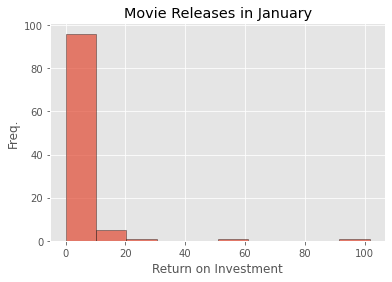

In [55]:
january_data = all_recent.loc[all_recent['release_month'] == 1]

# Create the histogram
plt.hist(january_data['return_on_investment'], bins=10, alpha=0.7, edgecolor='black')

plt.xlabel('Return on Investment')
plt.ylabel('Freq.')
plt.title('Movie Releases in January')

plt.show()

#### If you run the above histogram for all the months, you can see that generally they are not normally distributed.

In [56]:
#t test comparing one month to the rest of the months combined
alpha = 0.05
january = all_recent.loc[all_recent['release_month']==10]
other_months = all_recent.loc[all_recent['release_month']!=10]

statistic, pvalue = stats.ttest_ind(january['return_on_investment'], other_months['return_on_investment'], equal_var=False)
pvalue / 2 #we want our test to be one-sided

0.08340016753883756

In [57]:
pvalue/2 < alpha

False

#### We fail to reject the null. There is no statistical difference in ROI between January and the rest of the months of the year.


### Going further and breaking it down by season.

In [58]:
winter = all_recent.loc[all_recent['release_month'].isin([1, 2, 12])]
spring = all_recent.loc[all_recent['release_month'].isin([3, 4, 5])]
summer = all_recent.loc[all_recent['release_month'].isin([6, 7, 8])]
fall = all_recent.loc[all_recent['release_month'].isin([9, 10, 11])]

In [59]:
all_recent['season'] = all_recent['release_month'].map({
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
})

<ipython-input-59-ba85effae049>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_recent['season'] = all_recent['release_month'].map({


In [60]:
all_recent

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,return_on_investment,year,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_class,Horror,release_month,season
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2.546673,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624,high_budget,False,5,Spring
1,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,0.427892,2019,tt6565702,Dark Phoenix,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,high_budget,False,6,Summer
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,4.243841,2015,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,high_budget,False,5,Spring
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,6.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,high_budget,False,4,Spring
4,9,2017-11-17,Justice League,300000000,229024295,655945209,2.186484,2017,tt0974015,Justice League,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135,high_budget,False,11,Fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,59,2011-11-25,The Ridges,17300,0,0,0.000000,2011,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127,low_budget,True,11,Fall
1586,62,2014-12-31,Stories of Our Lives,15000,0,0,0.000000,2014,tt3973612,Stories of Our Lives,Stories of Our Lives,60.0,Drama,7.5,85,low_budget,False,12,Winter
1587,73,2012-01-13,Newlyweds,9000,4584,4584,0.509333,2012,tt1880418,Newlyweds,Newlyweds,95.0,"Comedy,Drama",6.4,1436,low_budget,False,1,Winter
1588,78,2018-12-31,Red 11,7000,0,0,0.000000,2018,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,low_budget,True,12,Winter


In [61]:
#One-way ANOVA for return on investment based on season that the movie is released in 
model = ols('return_on_investment ~ C(season)', data=all_recent).fit()
anova_table = sm.stats.anova_lm(model)

print("ANOVA Table:")
print(anova_table)

#Tukey HSD post hoc test
tukey_result = pairwise_tukeyhsd(all_recent['return_on_investment'], all_recent['season'])

print("Tukey HSD Post Hoc Test:")
print(tukey_result)

ANOVA Table:
               df        sum_sq    mean_sq         F    PR(>F)
C(season)     3.0     21.267851   7.089284  0.207795  0.891042
Residual   1566.0  53426.905650  34.116798       NaN       NaN
Tukey HSD Post Hoc Test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Fall Spring  -0.2254    0.9 -1.2823 0.8315  False
  Fall Summer   0.0896    0.9 -0.9785 1.1577  False
  Fall Winter  -0.1087    0.9  -1.162 0.9447  False
Spring Summer    0.315 0.8694 -0.7786 1.4086  False
Spring Winter   0.1167    0.9 -0.9625  1.196  False
Summer Winter  -0.1983    0.9 -1.2885 0.8919  False
---------------------------------------------------


#### Again, we fail to reject the null hypothesis because the pvalue for each pairwise analysis is greater than alpha.